In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
data = pd.read_csv('AmesHousing.tsv', sep='\t')

In [3]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
def transform_features(train):
    return train

In [5]:
def select_features(train):
    return train[['Gr Liv Area', 'SalePrice']]

In [6]:
def train_and_test(data):
    
    train = data[:1460]
    test = data[1460:]
    
    numerical_train = select_features(train).select_dtypes(include=['integer', 'float'])
    numerical_test = select_features(test).select_dtypes(include=['integer', 'float'])
    
    features = numerical_train.columns.drop('SalePrice')
    
    lr = LinearRegression()
    lr.fit(numerical_train[features], numerical_train['SalePrice'])
    yhat = lr.predict(numerical_test[features])
    
    mse = mean_squared_error(yhat, test['SalePrice'])
    rmse = np.sqrt(mse)
    
    return rmse

In [7]:
rmse = train_and_test(data)
rmse

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


57088.25161263909

# Feature engineering

In [8]:
def transform_features(df):
    
    # Remove columns with more than 25% of data missing

    null_counts = df.isnull().sum()
    keep = null_counts[null_counts <= (0.25 * len(df))]
    df = df[keep.index]
    
    # Remove text columns with any missing values

    text_data = df.select_dtypes(include=['object'])
    null_counts = text_data.isnull().sum()
    cols_to_drop = null_counts[null_counts > 0].index
    df = df.drop(cols_to_drop, axis=1)
    
    # Find numeric columns with less than 25% missing values, fill with most common value

    numeric_data = df.select_dtypes(include=['float', 'int'])
    null_vals = numeric_data.isnull().sum()
    five_per = null_vals[(null_vals <= 0.25 * len(df)) & (null_vals > 0)]
    fill_na_vals = numeric_data[five_per.index].mode().to_dict(orient='records')[0]
    df = df.fillna(fill_na_vals)
    
    # Add new features

    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    
    df['Years Before Sale'] = years_sold
    df['Years Since Remodel'] = years_since_remod

    # Drop rows in new columns with negative values
    df = df[(df['Years Before Sale'] >= 0) & (df['Years Since Remodel'] >= 0)]

    # Remove original feature columns
    df.drop(['Year Built', 'Year Remod/Add'], axis=1, inplace=True)
    
    # Drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)

    # Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

    return df

In [9]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.367312413066

# Feature Selection

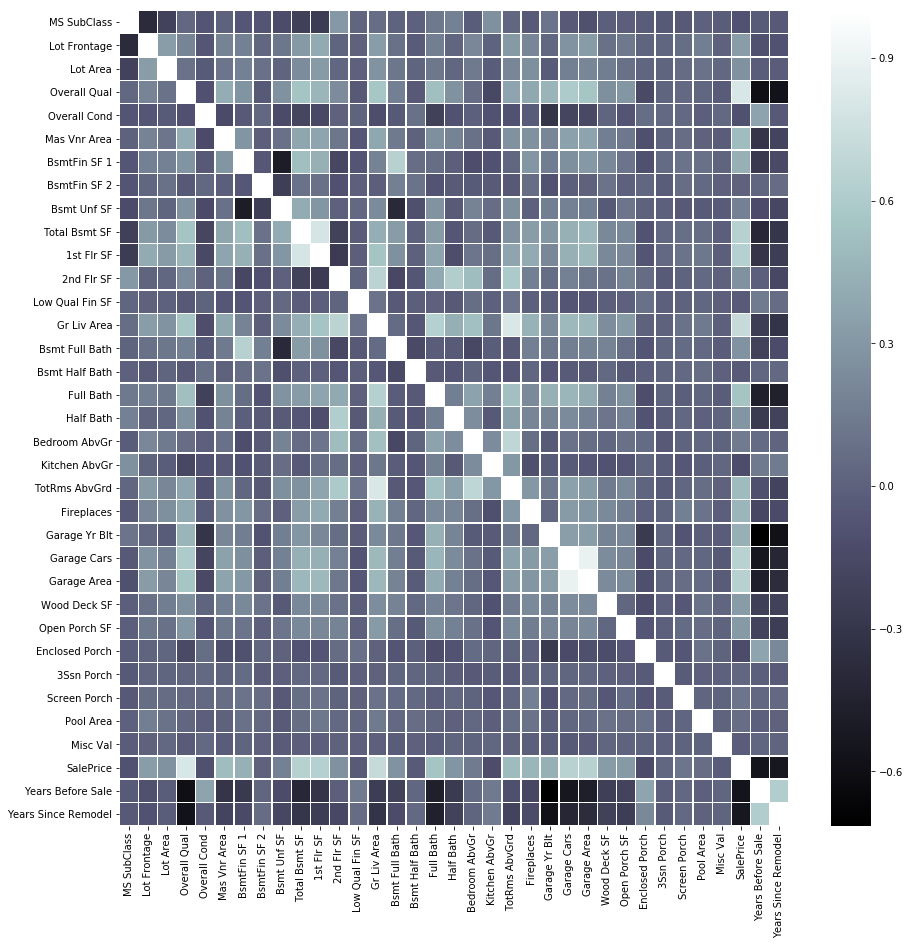

In [10]:
fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(transform_df.corr(), ax=ax, linewidths=.5, cmap='bone')

In [11]:
numerical_df = transform_df.select_dtypes(include=['int', 'float'])
numerical_df

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remodel
0,20,141.0,31770,6,5,112.0,639.0,0.0,441.0,1080.0,...,210,62,0,0,0,0,0,215000,50,50
1,20,80.0,11622,5,6,0.0,468.0,144.0,270.0,882.0,...,140,0,0,0,120,0,0,105000,49,49
2,20,81.0,14267,6,6,108.0,923.0,0.0,406.0,1329.0,...,393,36,0,0,0,0,12500,172000,52,52
3,20,93.0,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,...,0,0,0,0,0,0,0,244000,42,42
4,60,74.0,13830,5,5,0.0,791.0,0.0,137.0,928.0,...,212,34,0,0,0,0,0,189900,13,12
5,60,78.0,9978,6,6,20.0,602.0,0.0,324.0,926.0,...,360,36,0,0,0,0,0,195500,12,12
6,120,41.0,4920,8,5,0.0,616.0,0.0,722.0,1338.0,...,0,0,170,0,0,0,0,213500,9,9
7,120,43.0,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,...,0,82,0,0,144,0,0,191500,18,18
8,120,39.0,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,...,237,152,0,0,0,0,0,236500,15,14
9,60,60.0,7500,7,5,0.0,0.0,0.0,994.0,994.0,...,140,60,0,0,0,0,0,189000,11,11


In [12]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2           0.006127
Misc Val               0.019273
3Ssn Porch             0.032268
Bsmt Half Bath         0.035875
Low Qual Fin SF        0.037629
Pool Area              0.068438
MS SubClass            0.085128
Overall Cond           0.101540
Screen Porch           0.112280
Kitchen AbvGr          0.119760
Enclosed Porch         0.128685
Bedroom AbvGr          0.143916
Bsmt Unf SF            0.182751
Lot Area               0.267520
2nd Flr SF             0.269601
Bsmt Full Bath         0.276258
Half Bath              0.284871
Open Porch SF          0.316262
Wood Deck SF           0.328183
Lot Frontage           0.333681
BsmtFin SF 1           0.439284
Garage Yr Blt          0.442216
Fireplaces             0.474831
TotRms AbvGrd          0.498574
Mas Vnr Area           0.506983
Years Since Remodel    0.534985
Full Bath              0.546118
Years Before Sale      0.558979
1st Flr SF             0.635185
Garage Area            0.641425
Total Bsmt SF          0.644012
Garage C

In [13]:
# Only keep features with r > 0.4

abs_corr_coeffs[abs_corr_coeffs > 0.4]

BsmtFin SF 1           0.439284
Garage Yr Blt          0.442216
Fireplaces             0.474831
TotRms AbvGrd          0.498574
Mas Vnr Area           0.506983
Years Since Remodel    0.534985
Full Bath              0.546118
Years Before Sale      0.558979
1st Flr SF             0.635185
Garage Area            0.641425
Total Bsmt SF          0.644012
Garage Cars            0.648361
Gr Liv Area            0.717596
Overall Qual           0.801206
SalePrice              1.000000
Name: SalePrice, dtype: float64

We can probably drop one in the following pairs: (Total Bsmt SF, 1st Flr SF), (Garage Cars, Garage Area), and (TotRms AbvGrd, Gr Liv Area) because they are highly correlated with each other

In [14]:
print('(Total Bsmt SF, 1st Flr SF):', numerical_df.corr()['Total Bsmt SF'].abs()['1st Flr SF'])
print('(Garage Cars, Garage Area):',numerical_df.corr()['Garage Cars'].abs()['Garage Area'])
print('(TotRms AbvGrd, Gr Liv Area):',numerical_df.corr()['TotRms AbvGrd'].abs()['Gr Liv Area'])

(Total Bsmt SF, 1st Flr SF): 0.7922267676471338
(Garage Cars, Garage Area): 0.8888662389238103
(TotRms AbvGrd, Gr Liv Area): 0.8060920748967705


Drop Garage Cars and TotRms AbvGrd because they are numerical (but actually categorical), and more of a hassle to work with, and drop Total Bsmt SF.

In [15]:
transform_df = transform_df.drop(['Total Bsmt SF', 'Garage Cars', 'TotRms AbvGrd'], axis=1)

In [16]:
# Drop columns with r < 0.4

cols_to_drop = abs_corr_coeffs[abs_corr_coeffs < 0.4].index
transform_df = transform_df.drop(cols_to_drop, axis=1)

In [17]:
# Columns that are meant to be categorical (tagged as nominal in the documentation)
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

- Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
- If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [18]:
transform_df.columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'BsmtFin SF 1', 'Heating',
       'Heating QC', 'Central Air', '1st Flr SF', 'Gr Liv Area', 'Full Bath',
       'Kitchen Qual', 'Functional', 'Fireplaces', 'Garage Yr Blt',
       'Garage Area', 'Paved Drive', 'SalePrice', 'Years Before Sale',
       'Years Since Remodel'],
      dtype='object')

In [19]:
# Figure out which of the features in nominal features are still in transform_df

transform_cat_cols = []
for feature in nominal_features:
    if feature in transform_df.columns:
        transform_cat_cols.append(feature)

transform_cat_cols

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

In [20]:
# Now figure out how many unique values each of the above has.

unique_counts = transform_df[transform_cat_cols].apply(lambda x: len(x.unique())).sort_values()
unique_counts

Street           2
Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Roof Style       6
Foundation       6
Heating          6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [21]:
# Drop any features with more than 10 unique values

cols_to_drop = unique_counts[unique_counts > 10].index
transform_df = transform_df.drop(cols_to_drop, axis=1)

In [22]:
# For the remaining columns, check to see if more than 95% of the values belong to a specific category (very low variability)

keep_cols = unique_counts.index.drop(cols_to_drop)

def check_low_variability(df, cols, variability_thresh=0.95):
    """Checks for low variability in categorical columns."""
    
    low_var = []
    
    for col in cols:
        proportions = df[col].value_counts() / len(df[col])
        proportions = proportions[proportions >= variability_thresh]
        if len(proportions) > 0:
            low_var.append(col)
    
    return low_var

In [23]:
low_var = check_low_variability(transform_df, keep_cols)
low_var

['Street', 'Heating', 'Condition 2', 'Roof Matl']

In [24]:
# Drop low variability columns

transform_df = transform_df.drop(low_var, axis=1)

In [25]:
# Convert the remaining text columns to categorical

text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')

# Create dummy columns and add back to df
categoricals = transform_df.select_dtypes(include=['category'])
transform_df = pd.concat([transform_df, pd.get_dummies(categoricals)], axis=1)

# Delete original columns from the df
transform_df = transform_df.drop(categoricals.columns, axis=1)

May also need to transform some numerical features to categorical:

Overall Qual (1-10)<br>
Full Bath (0-4)<br>
Fireplaces (0-4)<br>

In [26]:
# Convert 'Overall Qual', 'Full Bath', 'Fireplaces' from numerical to category

num_to_cat = ['Overall Qual', 'Full Bath', 'Fireplaces']
for col in num_to_cat:
    transform_df[col] = transform_df[col].astype('category')
    transform_df = pd.concat([transform_df, pd.get_dummies(transform_df[col], prefix=col)], axis=1)
    transform_df = transform_df.drop(col, axis=1)

In [27]:
def transform_features(df, missing_data_thresh=0.25):
    
    # Remove columns with more than missing_data_thresh% of data missing

    null_counts = df.isnull().sum()
    keep = null_counts[null_counts <= (missing_data_thresh * len(df))]
    df = df[keep.index]
    
    # Remove text columns with any missing values

    text_data = df.select_dtypes(include=['object'])
    null_counts = text_data.isnull().sum()
    cols_to_drop = null_counts[null_counts > 0].index
    df = df.drop(cols_to_drop, axis=1)
    
    # Find numeric columns with less than missing_data_thresh% missing values, fill with most common value

    numeric_data = df.select_dtypes(include=['float', 'int'])
    null_vals = numeric_data.isnull().sum()
    five_per = null_vals[(null_vals <= 0.25 * len(df)) & (null_vals > 0)]
    fill_na_vals = numeric_data[five_per.index].mode().to_dict(orient='records')[0]
    df = df.fillna(fill_na_vals)
    
    # Construct new features,'Years Before Sale' and 'Year Since Remodel', from existing features

    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    
    df['Years Before Sale'] = years_sold  # Add new features to the df
    df['Years Since Remodel'] = years_since_remod

    df = df[(df['Years Before Sale'] >= 0) & (df['Years Since Remodel'] >= 0)]  # Drop rows in new columns with negative values
    df.drop(['Year Built', 'Year Remod/Add'], axis=1, inplace=True)  # Remove original feature columns
    
    # Drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)

    # Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

    return df


def select_features(df, corr_thresh=0.4, unique_thresh=10, variability_thresh=0.95):
    
    # Drop 'Total Bsmt SF', 'Garage Cars', 'TotRms AbvGrd' because they are highly correlated with 
    # '1st Flr SF', 'Garage Area', and 'Gr Liv Area', respectively (thus repetitive).
    
    df = df.drop(['Total Bsmt SF', 'Garage Cars', 'TotRms AbvGrd'], axis=1)
    
    # Drop features that have a corr coefficient r < corr_thresh with 'SalePrice'
    
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    cols_to_drop = abs_corr_coeffs[abs_corr_coeffs < corr_thresh].index
    df = df.drop(cols_to_drop, axis=1)
    
    # Drop categorical features with more than unique_thresh values
    # First figure out which categorical features are still in the df and convert them to 'category' dtypes.
    
    cols_to_transform = []
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", 
                        "Lot Config", "Neighborhood", "Condition 1", "Condition 2", "Bldg Type", 
                        "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", 
                        "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                        "Misc Feature", "Sale Type", "Sale Condition"]
    
    for feature in nominal_features:
        if feature in df.columns:
            cols_to_transform.append(feature)
    
    unique_counts = df[cols_to_transform].apply(lambda x: len(x.unique())).sort_values()  # Num of unique values
    cols_to_drop = unique_counts[unique_counts > unique_thresh].index
    cols_to_keep = unique_counts.index.drop(cols_to_drop)
    df = df.drop(cols_to_drop, axis=1)
    
    # For remaining features, check to see if more than variability_thresh% of the values belong 
    # to a specific category (very low variability). Drop these features.
    
    low_var = check_low_variability(df, cols_to_keep) # Function returns a list of low var columns
    df = df.drop(low_var, axis=1) # Drop low variability columns
    
    # Convert the remaining text columns to categorical

    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')

    # Create dummy columns and add back to df
    categoricals = df.select_dtypes(include=['category'])
    df = pd.concat([df, pd.get_dummies(categoricals)], axis=1)
    
    # Delete original columns from the df
    df = df.drop(categoricals.columns, axis=1)
    
    # Convert 'Overall Qual', 'Full Bath', 'Fireplaces' from numerical to category
    num_to_cat = ['Overall Qual', 'Full Bath', 'Fireplaces']
    for col in num_to_cat:
        df[col] = df[col].astype('category')
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        df = df.drop(col, axis=1)

    return df


def train_and_test(df, k=0):
    
    features = df.columns.drop('SalePrice')
    lr = LinearRegression()
    
    if k == 0:
        train = data[:1460]
        test = data[1460:]

        lr.fit(train[features], train['SalePrice'])
        prediction = lr.predict(test[features])

        mse = mean_squared_error(prediction, test['SalePrice'])
        rmse = np.sqrt(mse)

        return rmse
    
    elif k == 1:
        
        shuffled_indices = np.random.permutation(df.index)
        df = df.iloc[shuffled_indices]
        fold_one = data[:1460]
        fold_two = data[1460:]
        
        lr.fit(fold_one[features], fold_one['SalePrice'])
        prediction = lr.predict(fold_two[features])

        mse = mean_squared_error(prediction, fold_two['SalePrice'])
        rmse = np.sqrt(mse)

        return rmse
    
    else:
        
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr = LinearRegression()
            lr.fit(train[features], train['SalePrice'])
            prediction = lr.predict(test[features]).astype(int)
            predict_series = pd.Series(prediction, index=test['SalePrice'].index, name='Prediction')

            mse = mean_squared_error(prediction, test['SalePrice'])
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
            
            predict_and_true = pd.concat([predict_series, test['SalePrice']], axis=1).dropna()
        
        print(rmse_values)
        
        return np.mean(rmse_values), predict_and_true

In [28]:
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse, predict_and_true = train_and_test(filtered_df, k=10)

rmse

[24375.978458492158, 24815.605714677775, 20993.613628780997, 44891.006801076925, 24294.806566193056, 27682.54713911303, 25466.42522929051, 25053.785936392436, 20761.179889168412, 32289.524647989954]


27062.447401117526

In [29]:
predict_and_true

,Prediction,SalePrice
6,212202,213500
20,213893,190000
31,97070,88000
35,129468,146000
45,197674,224000
46,476575,500000
59,337827,333168
69,262088,262500
72,233769,233000
84,141026,148000
